<a href="https://colab.research.google.com/github/last-war/HW_DataScience/blob/Homework-08/hw_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [158]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [159]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [160]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [161]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        # Место для вашего кода
        self.w = tf.Variable(tf.random.truncated_normal((in_features, out_features), stddev=0.1, name="w"))
        self.b = tf.Variable(tf.zeros([out_features], dtype=tf.float32, name="b"))
        if out_features == 10:
          self.activation = 'softmax'
        else:
          self.activation = 'relu'

    def __call__(self, x):
        # Место для вашего кода
        y = tf.matmul(x, self.w) + self.b
        if self.activation == 'softmax':
            return tf.nn.softmax(y)
        return tf.nn.relu(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    # Место для вашего кода
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

    # Второй слой, состоящий из 256 нейронов
    # Место для вашего кода
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

    # Выходной слой
    # Место для вашего кода
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):
    # Место для вашего кода
    x = self.layer_1(x)
    x = self.layer_2(x)

    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax.
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью
    # принадлежности входного объекта к одному из 10 классов

    # Место для вашего кода
    x = self.layer_3(x)
    #return tf.nn.softmax(x)
    return x

In [162]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    # Место для вашего кода
    #correct_prediction = tf.equal(
    #    tf.argmax(y_pred, 1),
    #    tf.cast(y_true, tf.int64)
    #)
    #return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()

In [163]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = nn(input_x)
    loss = cross_entropy(pred, output_y)

    # Создадим оптимизируемых список параметров
    # Место для вашего кода
    trainable_variables = nn.variables

    # Вычислим по ним значение градиента
    # Место для вашего кода
    grads = g.gradient(loss, trainable_variables)

    # Модифицируем параметры
    # Место для вашего кода
    optimizer.apply_gradients(zip(grads, trainable_variables))
  return pred

In [164]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)): # Место для вашего кода:
    # Обновляем веса нейронной сети
    # Место для вашего кода
    pred = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        # Место для вашего кода
        print(f'{step}')
        curcross = cross_entropy(pred, batch_y)
        loss_history.append(curcross)
        cur_acc = accuracy(pred, batch_y)
        accuracy_history.append(cur_acc)
        print(curcross)
        print(cur_acc)
        #overfit stoper
        if cur_acc.numpy() > 0.99:
          break


0
tf.Tensor(534.29675, shape=(), dtype=float32)
tf.Tensor(0.25390625, shape=(), dtype=float32)
100
tf.Tensor(59.21643, shape=(), dtype=float32)
tf.Tensor(0.921875, shape=(), dtype=float32)
200
tf.Tensor(50.268986, shape=(), dtype=float32)
tf.Tensor(0.92578125, shape=(), dtype=float32)
300
tf.Tensor(48.348053, shape=(), dtype=float32)
tf.Tensor(0.96484375, shape=(), dtype=float32)
400
tf.Tensor(32.956013, shape=(), dtype=float32)
tf.Tensor(0.96484375, shape=(), dtype=float32)
500
tf.Tensor(46.587364, shape=(), dtype=float32)
tf.Tensor(0.95703125, shape=(), dtype=float32)
600
tf.Tensor(25.36464, shape=(), dtype=float32)
tf.Tensor(0.98046875, shape=(), dtype=float32)
700
tf.Tensor(15.893387, shape=(), dtype=float32)
tf.Tensor(0.9921875, shape=(), dtype=float32)


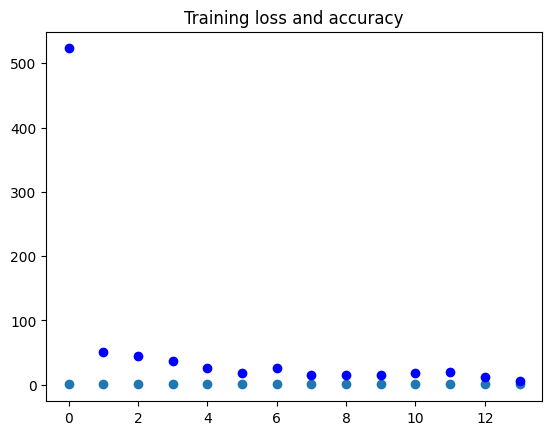

<Figure size 640x480 with 0 Axes>

In [ ]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

# Место для вашего кода
epochs = range(len(accuracy_history))

plt.plot(epochs, accuracy_history, 'o', label='Training accuracy')
plt.plot(epochs, loss_history, 'bo', label='Training Loss')
plt.title('Training loss and accuracy')

plt.figure()

plt.show()

In [ ]:
# Вычислите точность обученной нейросети

pred = neural_net(x_test)
# Место для вашего кода
curcross = cross_entropy(pred, y_test)
cur_acc = accuracy(pred, y_test)
print(curcross)
print(cur_acc)



tf.Tensor(989.6424, shape=(), dtype=float32)
tf.Tensor(0.9689, shape=(), dtype=float32)


label =8
pred =8


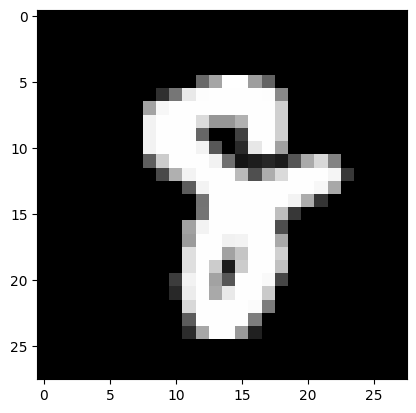

label =6
pred =6


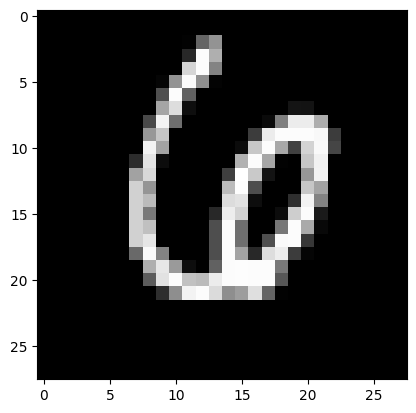

label =7
pred =7


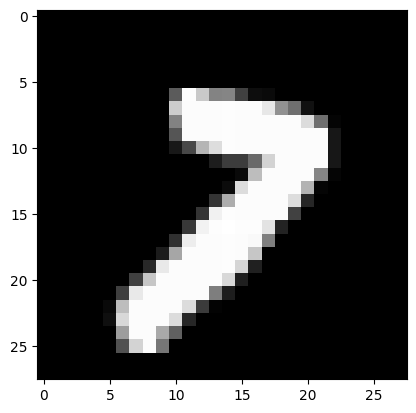

label =7
pred =7


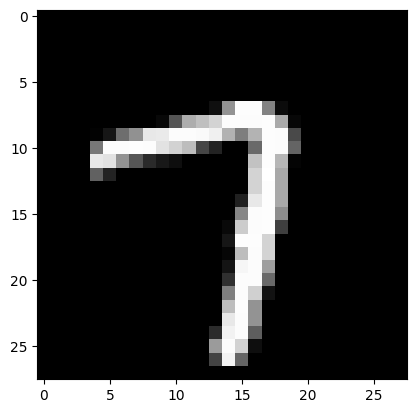

label =5
pred =5


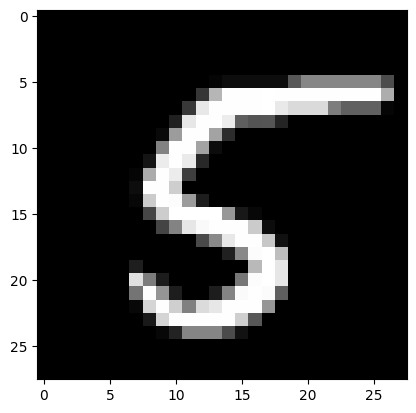

label =3
pred =3


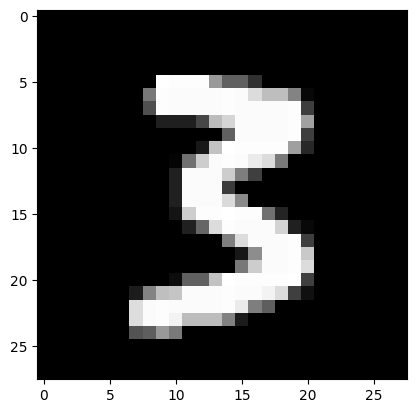

label =8
pred =8


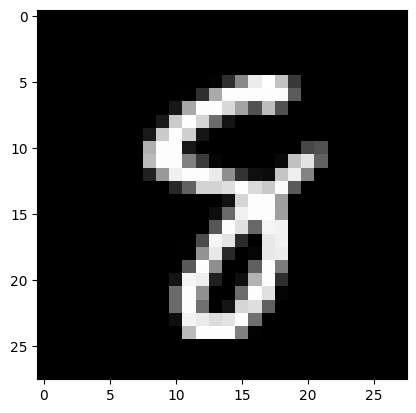

label =9
pred =9


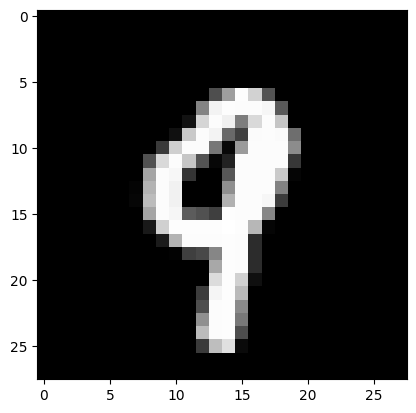

label =0
pred =0


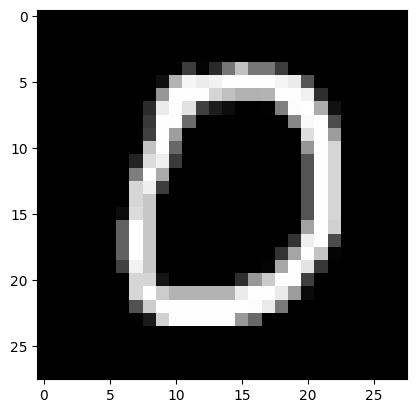

label =4
pred =4


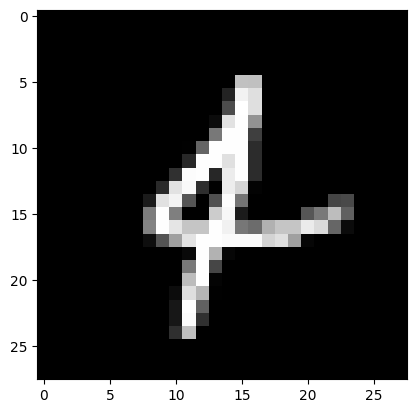

In [175]:
import random
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

# Место для вашего кода
for itr in range(10):
  id_pic = random.randint(0, x_test.shape[1])
  print(f'label ={y_test[id_pic]}')

  pred = neural_net(x_test[id_pic].reshape([-1, num_features]))
  print(f'pred ={np.argmax(pred)}')
  plt.imshow(x_test[id_pic].reshape(28, 28), cmap="gray")
  plt.show()


Висновок:
створена нейморежера помиляеться рідко. Проте варто зазначити, що й валідаційний і навчальний набір створені в одному стилі та розмірності.